In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom

In [2]:
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2001,MP Pelvis_2001,MP\CT.2.25.122959172090682991274033812218091597619.dcm"
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2001,MP Pelvis_2001,MP\CT.2.25.53134265348401973381541910902006399597.dcm"
data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [3]:
def simulate_breath_sine(kspace):
    dim = kspace.shape
    x = np.arange(0, kspace.shape[1])
    y = np.arange(0, kspace.shape[0])
    xx, yy = np.meshgrid(x, y)

    # Respiratory Frequency (alpha)
    rHz = 0.1 + 5*np.random.uniform()
    # Shift along PE direction (delta)
    dPos = 0 + 20*np.random.uniform()
    # Phase (beta)
    Phase = (np.pi/4)*np.random.uniform()
    # ky0
    Start = round(0.5*dim[0]);

    # Make periodical motion
    Resp_sig = np.arange(0, kspace.shape[0])
    Resp_sig = dPos*np.sin(-2*np.pi*rHz*Resp_sig/kspace.shape[0] + Phase)
    #     Resp_sig((dim(1)-Start-1):end) = 0;
    #     Resp_sig = circshift(Resp_sig, [0 Start]);
    Resp_sig = np.reshape(Resp_sig, (kspace.shape[0], 1))
    #     Resp_sig(restp) = Resp_sig;

    #     pos_change_x(:,:,jj) = repmat(Resp_sig, [1 size(in,2)]);
    pos_change_x = np.tile(Resp_sig, [1, kspace.shape[1]])

    # end
    
    # No motion in the center of k-space
    xc_min = round(kspace.shape[0]/2 - round(0.1*kspace.shape[0]))
    xc_max = round(kspace.shape[0]/2 + round(0.1*kspace.shape[0]))
    pos_change_x[xc_min:xc_max, :] = 0


    # Add phase error to k-space
    #y = shift_PE(image, pos_change_x)
    phasey = (yy - kspace.shape[0]/2)
    phasey = 2*np.pi*pos_change_x*phasey/kspace.shape[1]
    phase = np.exp(phasey*1j)
    kspace = kspace*phase
    
    #y = (y - np.mean(y)) / np.std(y)
   
    #return y, pos_change_x
    return kspace

In [4]:
def shift_PE(image, posy):
    kspace = transform_image_to_kspace(image)
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)
    
    phasey = (yy - image.shape[0]/2)
    phasey = 2*np.pi*posy*phasey/image.shape[1]
    phase = np.exp(phasey*1j)
    kspace = kspace*phase    
    img = transform_kspace_to_image(kspace)  
    return img

(-0.5, 319.5, 319.5, -0.5)

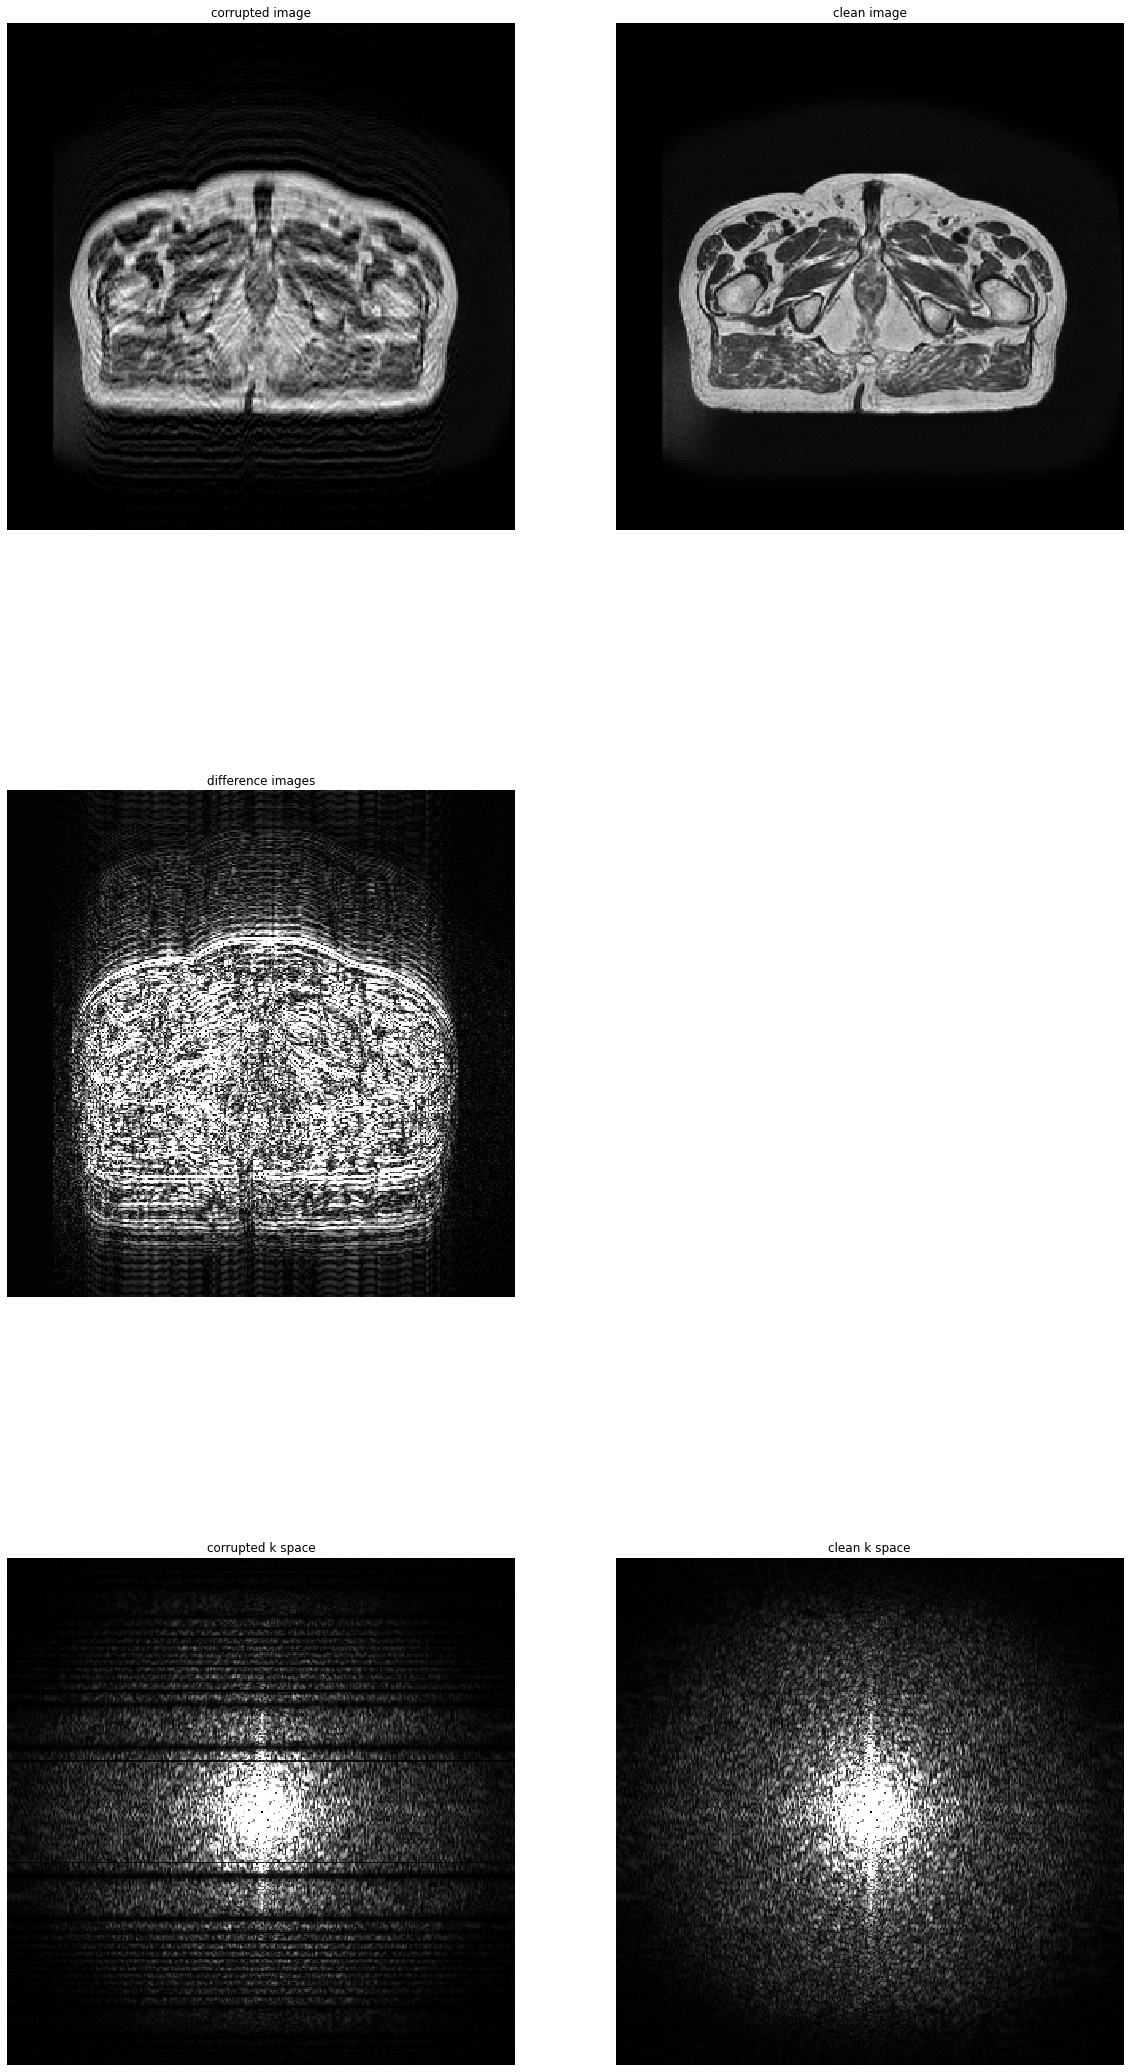

In [5]:
# plotting

kspace = transform_image_to_kspace(image)
kspace_sin = simulate_breath_sine(kspace)
img = transform_kspace_to_image(kspace_sin)
img = (img - np.mean(img)) / np.std(img)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [6]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(image, img))
print(np.mean(image), np.std(image))
print(np.mean(img), np.std(img))

0.09212658633139874
3.9968028886505634e-17 1.0
1.3322676295501878e-17 1.0


In [8]:
# the artefacts should be well-balanced in terms of MSE

import os
from sklearn.metrics import mean_squared_error

images_path_list = []
main_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis'
folders = os.listdir(main_path)
for folder in folders:
    folder_path = main_path + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)

error_motion_image_total = []

for image_path in images_path_list:
    
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    if (image.max() - image.min()) > 1e-5: # skip black images
        image = (image - np.mean(image)) / np.std(image)
        
        for i in range(1):
            kspace = transform_image_to_kspace(image)
            kspace_sin = simulate_breath_sine(kspace)
            img = transform_kspace_to_image(kspace_sin)
            img = (img - np.mean(img)) / np.std(img)
            
            error_motion_image = mean_squared_error(image, img)
            error_motion_image_total.append(error_motion_image)

In [9]:
print('average motion image error: {}'.format(sum(error_motion_image_total)/len(error_motion_image_total)))

average motion image error: 0.05217614783524777


In [10]:
min_init = np.min(image)
max_init = np.max(image)
image = (image - np.min(image)) / (np.max(image) - np.min(image))

kspace = transform_image_to_kspace(image)

x = np.linspace(-np.pi, np.pi, image.shape[1])
y = np.linspace(-np.pi, np.pi, image.shape[0])
#x = np.arange(0, image.shape[1])
#y = np.arange(0, image.shape[0])
xx, yy = np.meshgrid(x, y)

alpha = np.random.uniform(0.1, 5)
beta = np.random.uniform(0, np.pi/4)
delta = 2#np.random.uniform(0, 20)
phase = 2*np.pi*yy*delta*np.sin(alpha*yy+beta)

# preserve centre k-space lines
k_max = np.random.uniform(np.pi/10, np.pi/2)
phase[round(phase.shape[0]/2-k_max):round(phase.shape[0]/2+k_max), :] = 0

kspace_sin = kspace*np.exp(-1j*phase)

img = transform_kspace_to_image(kspace_sin)

img = img*(max_init - min_init) + min_init
img = (img - np.mean(img)) / np.std(img)

In [ ]:
# plotting

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [ ]:
mean_squared_error(image, img)

In [ ]:
x = np.linspace(-np.pi, np.pi, image.shape[1])
y = np.linspace(-np.pi, np.pi, image.shape[0])
kx, ky = np.meshgrid(x, y)

phase_ky = np.copy(ky)
ky0 = np.random.uniform(np.pi/10, np.pi/2)
alpha = np.random.uniform(0.1, 5)
phase_ky = np.sin(alpha*(ky-ky0))
#phase_ky[abs(ky) < ky0] = 0

kspace = transform_image_to_kspace(image)
kspace_sin = kspace*np.exp(-1j*phase_ky)
img = transform_kspace_to_image(kspace_sin)

plt.imshow(phase_ky)

In [ ]:
# plotting

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [ ]:
kspace.shape